In [1]:
!pip install -q -U transformers xgboost timm opencv-python 'numpy<2.0' 'pandas>=2.2'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 71.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.9/115.9 MB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 44.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.0/63.0 MB 23.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 74.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 566.1/566.1 kB 21.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 64.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 77.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6

In [2]:
# import huggingface_hub
# huggingface_hub.login()

In [3]:
import os
import glob
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from tqdm.auto import tqdm

import torch
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)
print(f"PyTorch: {torch.__version__}")
print(f"Device: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'CPU'}")

PyTorch: 2.6.0+cu124
Device: CPU


# Explore Data

In [4]:
PATH_DATA = '/kaggle/input/csiro-biomass'
PATH_TRAIN_CSV = os.path.join(PATH_DATA, 'train.csv')
PATH_TRAIN_IMG = os.path.join(PATH_DATA, 'train')
PATH_TEST_IMG = os.path.join(PATH_DATA, 'test')

df = pd.read_csv(PATH_TRAIN_CSV)
print(f"Dataset size: {df.shape}")
display(df.head())

Dataset size: (1785, 9)


sample_id              image_path Sampling_Date State  \
0  ID1011485656__Dry_Clover_g  train/ID1011485656.jpg      2015/9/4   Tas   
1    ID1011485656__Dry_Dead_g  train/ID1011485656.jpg      2015/9/4   Tas   
2   ID1011485656__Dry_Green_g  train/ID1011485656.jpg      2015/9/4   Tas   
3   ID1011485656__Dry_Total_g  train/ID1011485656.jpg      2015/9/4   Tas   
4         ID1011485656__GDM_g  train/ID1011485656.jpg      2015/9/4   Tas   

           Species  Pre_GSHH_NDVI  Height_Ave_cm   target_name   target  
0  Ryegrass_Clover           0.62         4.6667  Dry_Clover_g   0.0000  
1  Ryegrass_Clover           0.62         4.6667    Dry_Dead_g  31.9984  
2  Ryegrass_Clover           0.62         4.6667   Dry_Green_g  16.2751  
3  Ryegrass_Clover           0.62         4.6667   Dry_Total_g  48.2735  
4  Ryegrass_Clover           0.62         4.6667         GDM_g  16.2750

In [5]:
TARGET_COLS = [c for c in df.columns if c not in ['image_id', 'Image']]
print(f"Target columns: {TARGET_COLS}")
print(f"Number of targets: {len(TARGET_COLS)}")

Target columns: ['sample_id', 'image_path', 'Sampling_Date', 'State', 'Species', 'Pre_GSHH_NDVI', 'Height_Ave_cm', 'target_name', 'target']
Number of targets: 9


## Plot target distribution

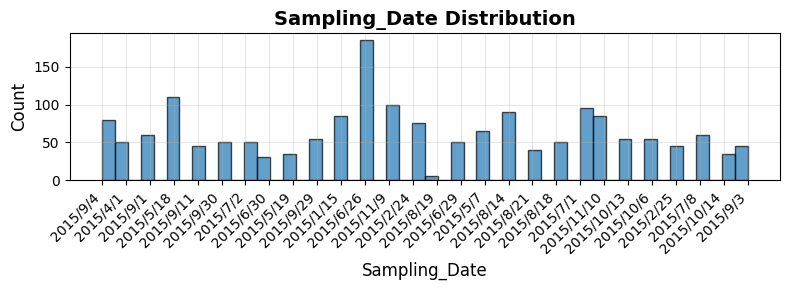

/tmp/ipykernel_13/1481063379.py:12: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout() # Adjust layout to prevent overlap


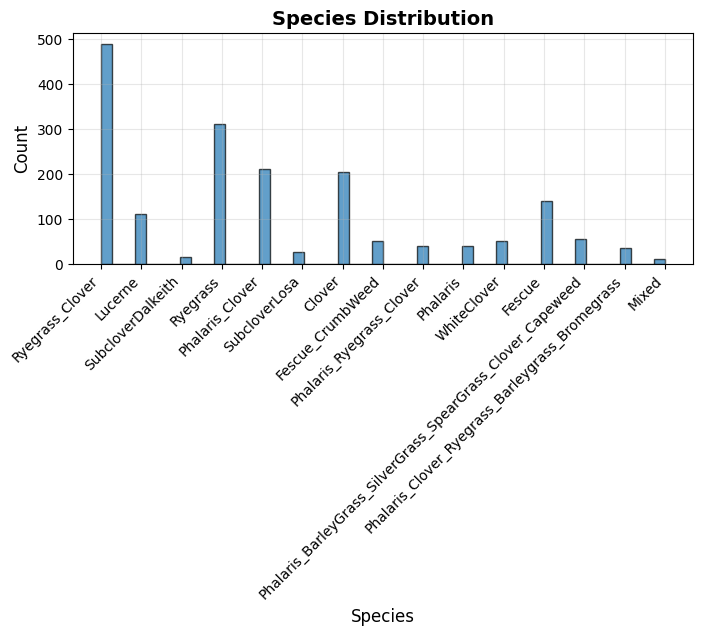

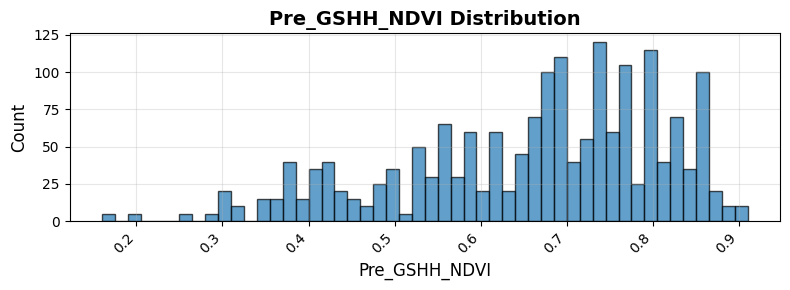

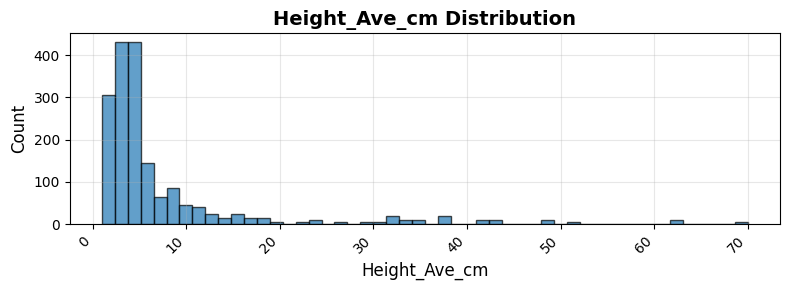

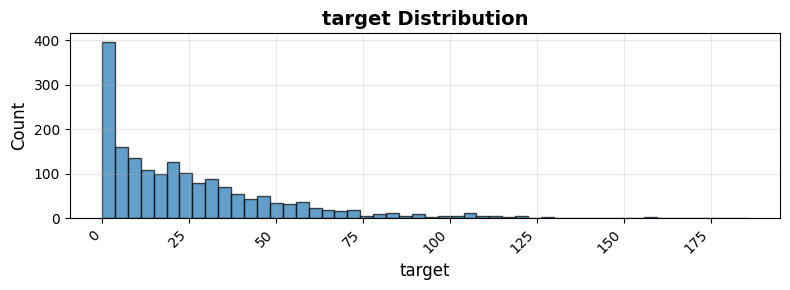

In [6]:
# Exclude non-numeric or identifier columns from histogram plotting
cols_to_plot = [col for col in TARGET_COLS if col not in ['sample_id', 'image_path', 'State', 'target_name']]

for col in cols_to_plot:
    plt.figure(figsize=(8, 3)) # Create a new figure for each histogram
    plt.hist(df[col].dropna(), bins=50, edgecolor='black', alpha=0.7)
    plt.xlabel(col, fontsize=12)
    plt.ylabel('Count', fontsize=12)
    plt.title(f'{col} Distribution', fontsize=14, fontweight='bold')
    plt.grid(alpha=0.3)
    plt.xticks(rotation=45, ha="right") # Rotate x-axis labels
    plt.tight_layout() # Adjust layout to prevent overlap
    plt.show()

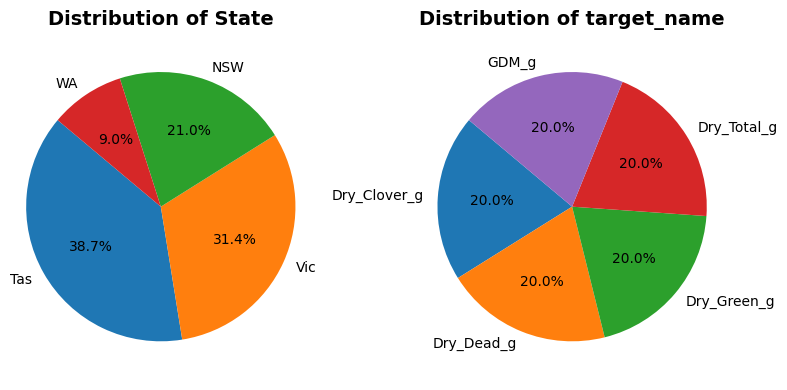

In [7]:
cols_to_plot = ['State', 'target_name']
n_rows, n_cols = 1, len(cols_to_plot)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 4 * n_rows))

# Ensure axes is an array even for a single subplot
axes = axes.flatten()

for ax, col in zip(axes, cols_to_plot):
    counts = df[col].value_counts()
    ax.pie(counts, labels=counts.index, autopct='%1.1f%%', startangle=140)
    ax.set_title(f'Distribution of {col}', fontsize=14, fontweight='bold')
    ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.tight_layout()
plt.show()

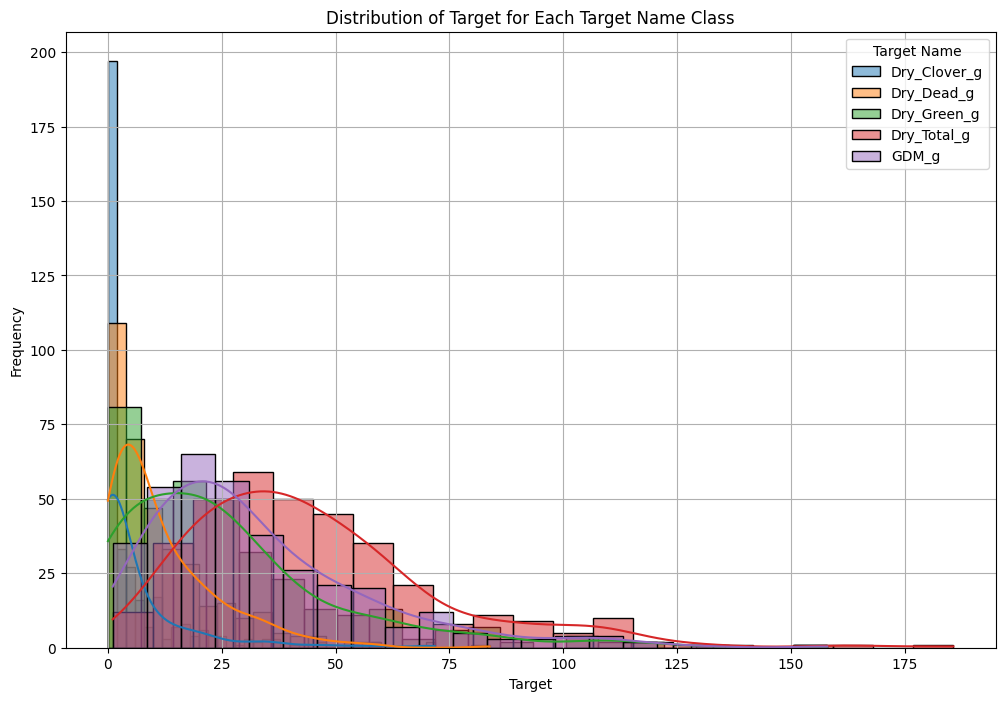

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

grouped_train_data = df.groupby('target_name')

plt.figure(figsize=(12, 8))
for target_name, group_data in grouped_train_data:
    sns.histplot(data=group_data, x='target', kde=True, label=target_name)

plt.title('Distribution of Target for Each Target Name Class')
plt.xlabel('Target')
plt.ylabel('Frequency')
plt.legend(title='Target Name')
plt.grid(True) # Added grid here
plt.show()

## Show sample images

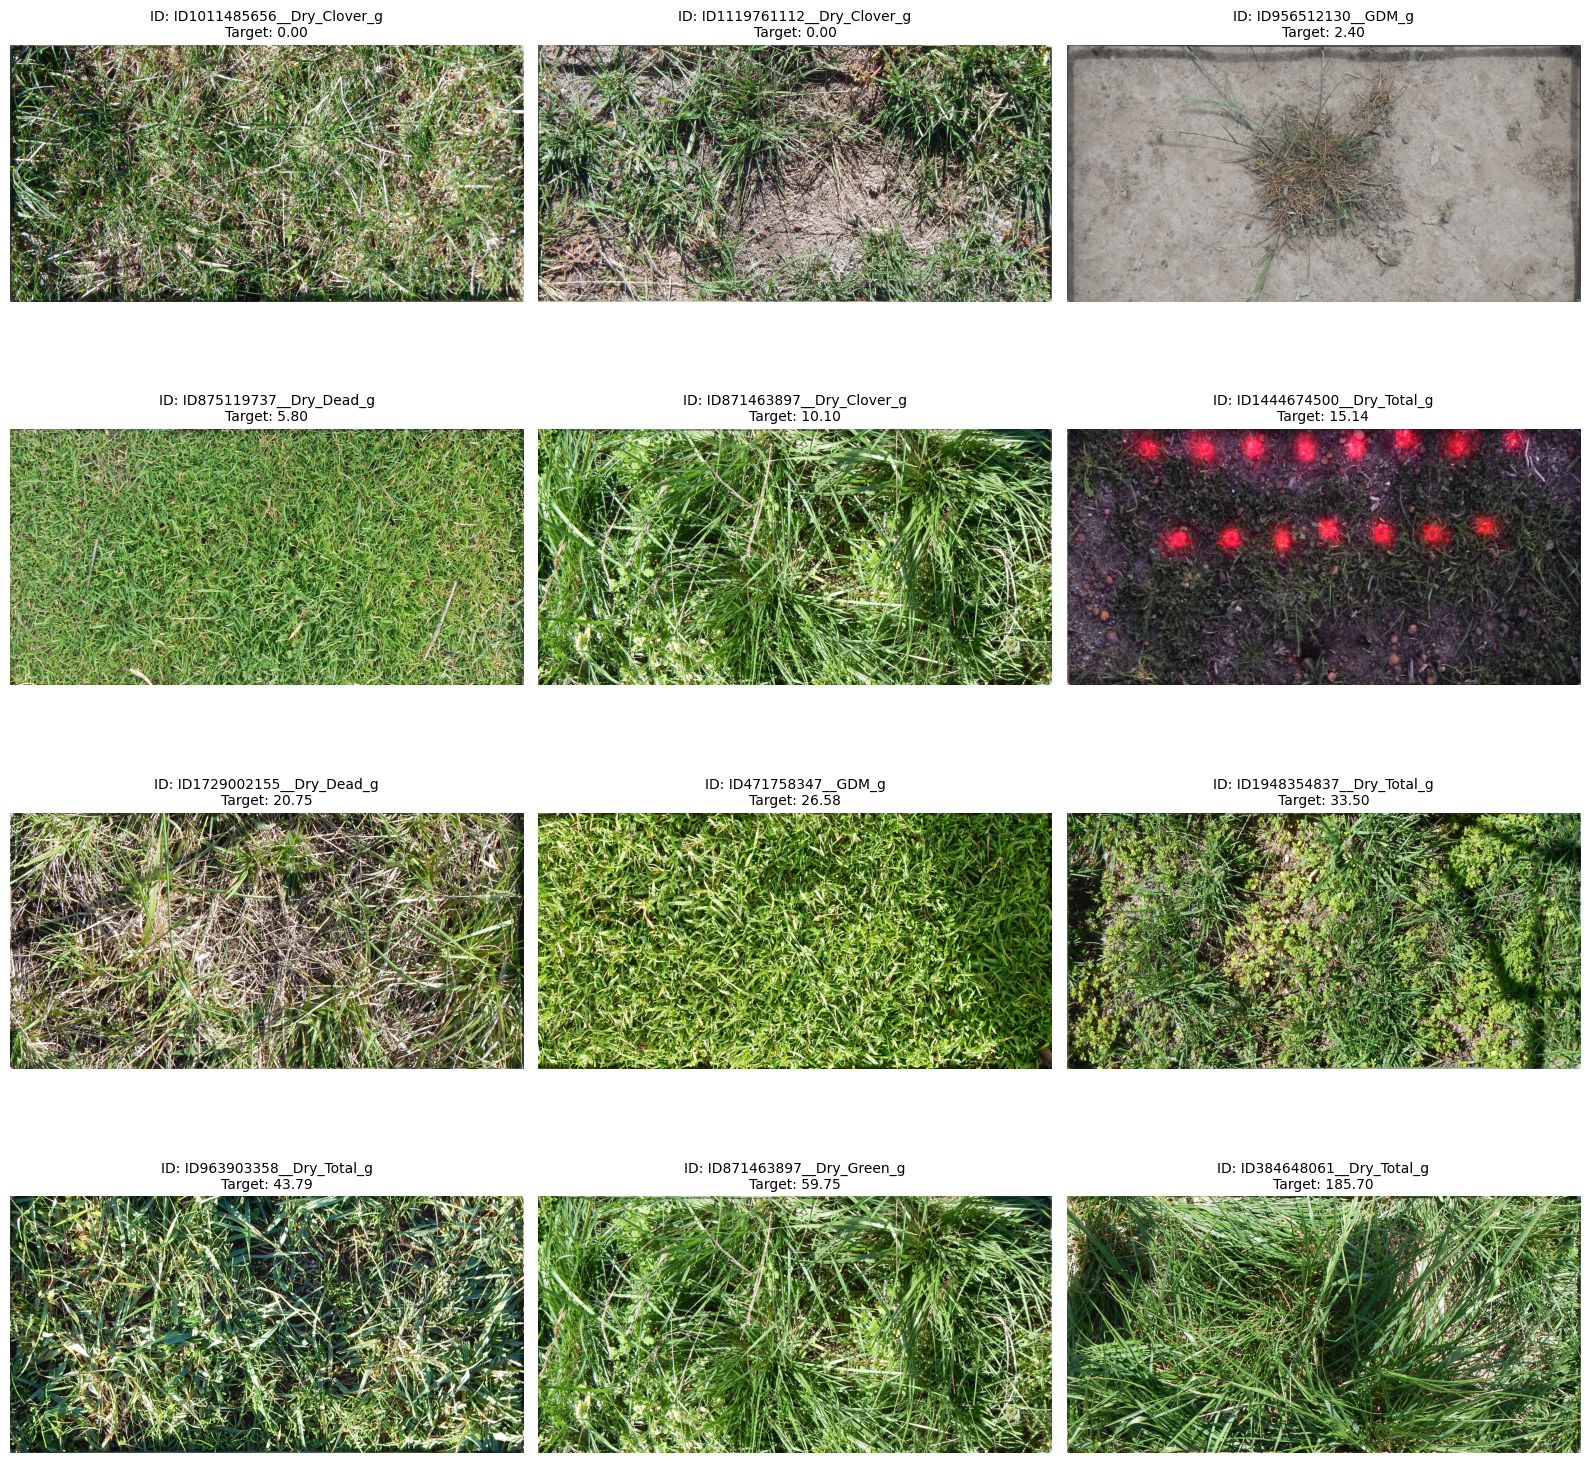

In [9]:
def show_images(df_sample, n=12, path_img=PATH_DATA):
    """Displays a linear sampling of images sorted by target value."""

    # Sort the DataFrame by the 'target' column
    df_sorted = df_sample.sort_values(by='target').reset_index(drop=True)

    # Perform linear sampling
    indices_to_show = np.linspace(0, len(df_sorted) - 1, n, dtype=int)
    df_to_show = df_sorted.iloc[indices_to_show]

    # Determine the number of rows and columns for subplots
    n_cols = 3  # You can adjust this number
    n_rows = (n + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 4 * n_rows))
    axes = axes.flatten()

    # Remove unused subplots if any
    for i in range(n, len(axes)):
        fig.delaxes(axes[i])

    for i, (idx, row) in enumerate(df_to_show.iterrows()):
        # Use image_path directly (includes train/ID....jpg)
        img_path = os.path.join(path_img, row['image_path'])

        if os.path.exists(img_path):
            img = Image.open(img_path).convert('RGB')
            axes[i].imshow(img)
            # Include the target value in the title
            title = f"ID: {row['sample_id']}\nTarget: {row['target']:.2f}"
            axes[i].set_title(title, fontsize=10)
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

# Example usage: Show 12 images linearly sampled based on target value
show_images(df, n=12)

# Feature extraction

In [10]:
from transformers import pipeline

# Define the feature extraction pipeline
feature_extractor = pipeline(
    # model="facebook/dinov3-convnext-tiny-pretrain-lvd1689m",
    model="/kaggle/input/metadino-v3-convnext/pytorch/default/2/dinov3-convnext-tiny-pretrain-lvd1689m",
    task="image-feature-extraction",
    device=0 if torch.cuda.is_available() else -1 # Use GPU if available
)

def extract_image_features_pipeline(image_path, feature_extractor, path_data):
    """
    Splits an image into two 1000x1000 parts and extracts features from each using a pipeline.
    """
    full_image_path = os.path.join(path_data, image_path)
    img = Image.open(full_image_path)#.convert('RGB')

    # Split the image into two 1000x1000 parts
    width, height = img.size
    img1 = img.crop((0, 0, width // 2, height))
    img2 = img.crop((width // 2, 0, width, height))

    # The pipeline expects PIL Images or paths, use 'inputs'
    extracted_features = feature_extractor(inputs=[img1, img2], pool=True)
    # extracted_features = feature_extractor(inputs=[img], pool=True)
    # print(f"extracted_features: {np.array(extracted_features).shape}")

    # Concatenate features from both parts
    combined_features = list(np.array(extracted_features).flatten())
    # print(f"combined_features: {len(combined_features)}")

    return combined_features

print("Image feature extraction function defined using pipeline.")

2025-11-02 23:56:44.983134: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762127805.269754      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762127805.346930      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
Device set to use cpu


Image feature extraction function defined using pipeline.


In [11]:
# Extract features for all images
image_features = {}
for index, row in tqdm(df.iterrows(), total=df.shape[0]):
    image_path = row['image_path']
    # Use the pipeline function
    features = extract_image_features_pipeline(image_path, feature_extractor, PATH_DATA)
    # Use the sample_id as the key for the features
    image_features[row['sample_id']] = features

print("Image feature extraction complete.")

  0%|          | 0/1785 [00:00<?, ?it/s]

Image feature extraction complete.


In [12]:
# Convert the image features dictionary to a DataFrame
image_features_df = pd.DataFrame.from_dict(image_features, orient='index')
image_features_df.index.name = 'sample_id'
image_features_df.columns = [f'img_feature_{i}' for i in range(image_features_df.shape[1])]

# One-hot encode the 'target_name' column
df_one_hot = pd.get_dummies(df['target_name'], prefix='target_name').astype(int) # Convert to int

# Merge the image features and one-hot encoded features with the original DataFrame
df_combined = df.merge(image_features_df, on='sample_id', how='left')
df_combined = df_combined.merge(df_one_hot, left_index=True, right_index=True)

print("Image features and one-hot encoded target names combined with the original DataFrame.")
display(df_combined.head())

Image features and one-hot encoded target names combined with the original DataFrame.


sample_id              image_path Sampling_Date State  \
0  ID1011485656__Dry_Clover_g  train/ID1011485656.jpg      2015/9/4   Tas   
1    ID1011485656__Dry_Dead_g  train/ID1011485656.jpg      2015/9/4   Tas   
2   ID1011485656__Dry_Green_g  train/ID1011485656.jpg      2015/9/4   Tas   
3   ID1011485656__Dry_Total_g  train/ID1011485656.jpg      2015/9/4   Tas   
4         ID1011485656__GDM_g  train/ID1011485656.jpg      2015/9/4   Tas   

           Species  Pre_GSHH_NDVI  Height_Ave_cm   target_name   target  \
0  Ryegrass_Clover           0.62         4.6667  Dry_Clover_g   0.0000   
1  Ryegrass_Clover           0.62         4.6667    Dry_Dead_g  31.9984   
2  Ryegrass_Clover           0.62         4.6667   Dry_Green_g  16.2751   
3  Ryegrass_Clover           0.62         4.6667   Dry_Total_g  48.2735   
4  Ryegrass_Clover           0.62         4.6667         GDM_g  16.2750   

   img_feature_0  ...  img_feature_1531  img_feature_1532  img_feature_1533  \
0      -0.770943  ...         -2.216053         -0.544089         -0.191438   
1      -0.770943  ...         -2.216053         -0.544089         -0.191438   
2      -0.770943  ...         -2.216053         -0.544089         -0.191438   
3      -0.770943  ...         -2.216053         -0.544089         -0.191438   
4      -0.770943  ...         -2.216053         -0.544089         -0.191438   

   img_feature_1534  img_feature_1535  target_name_Dry_Clover_g  \
0         -0.721959         -1.209875                         1   
1         -0.721959         -1.209875                         0   
2         -0.721959         -1.209875                         0   
3         -0.721959         -1.209875                         0   
4         -0.721959         -1.209875                         0   

   target_name_Dry_Dead_g  target_name_Dry_Green_g  target_name_Dry_Total_g  \
0                       0                        0                        0   
1                       1                        0                        0   
2                       0                        1                        0   
3                       0                        0                        1   
4                       0                        0                        0   

   target_name_GDM_g  
0                  0  
1                  0  
2                  0  
3                  0  
4                  1  

[5 rows x 1550 columns]

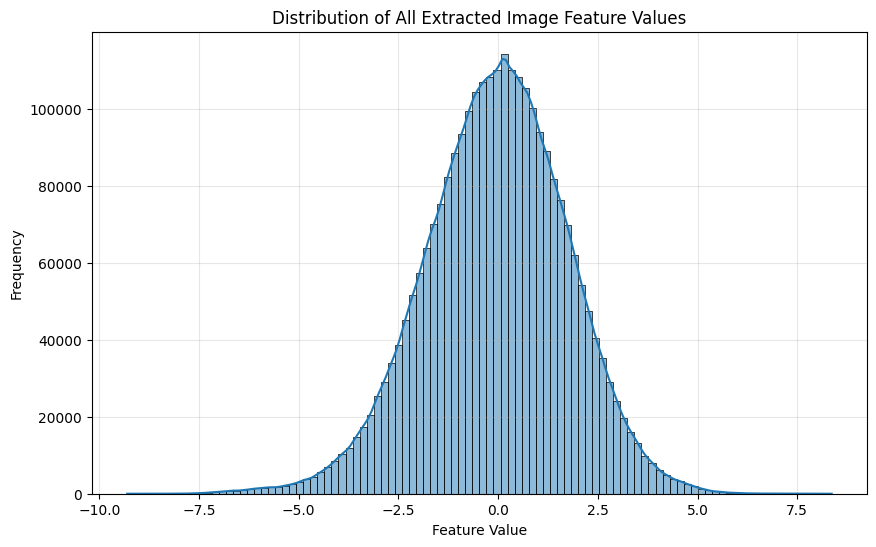

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# Flatten all image features into a single Series
image_features_cols = [col for col in df_combined.columns if col.startswith("img_feature_")]
all_features_flat = image_features_df[image_features_cols].values.flatten()
all_features_series = pd.Series(all_features_flat)

# Plot a single histogram for all features
plt.figure(figsize=(10, 6))
sns.histplot(all_features_series, kde=True, bins=100) # Adjust bins as needed
plt.title('Distribution of All Extracted Image Feature Values')
plt.xlabel('Feature Value')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
plt.show()

# Train Regressor

In [14]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Separate image features and other features
image_feature_cols = [col for col in df_combined.columns if col.startswith('img_feature_')]
other_features_cols = [col for col in df_combined.columns if col.startswith('target_name_')]

X_image_features = df_combined[image_feature_cols]
X_other_features = df_combined[other_features_cols]

# Standardize the image features before applying PCA
scaler = StandardScaler()
X_image_scaled = scaler.fit_transform(X_image_features)

# Apply PCA to reduce dimensionality
# You can adjust the number of components (n_components)
pca = PCA(n_components=75) # Example: Reduce components by 20x
X_image_pca = pca.fit_transform(X_image_scaled)

# Convert the PCA reduced features to a DataFrame
X_image_pca_df = pd.DataFrame(
    X_image_pca, index=df_combined.index,
    columns=[f'pca_img_feature_{i}' for i in range(pca.n_components)])

# Combine the PCA reduced image features with the other features
X_combined_pca = pd.concat([X_other_features, X_image_pca_df], axis=1)

print(f"Original number of image features: {X_image_features.shape[1]}")
print(f"Reduced number of image features after PCA: {X_image_pca_df.shape[1]}")
print(f"Total number of features for regression after PCA: {X_combined_pca.shape[1]}")

# Display the first few rows of the combined feature DataFrame after PCA
display(X_combined_pca.head())

Original number of image features: 1536
Reduced number of image features after PCA: 75
Total number of features for regression after PCA: 80


target_name_Dry_Clover_g  target_name_Dry_Dead_g  target_name_Dry_Green_g  \
0                         1                       0                        0   
1                         0                       1                        0   
2                         0                       0                        1   
3                         0                       0                        0   
4                         0                       0                        0   

   target_name_Dry_Total_g  target_name_GDM_g  pca_img_feature_0  \
0                        0                  0         -12.036552   
1                        0                  0         -12.036552   
2                        0                  0         -12.036552   
3                        1                  0         -12.036552   
4                        0                  1         -12.036552   

   pca_img_feature_1  pca_img_feature_2  pca_img_feature_3  pca_img_feature_4  \
0           7.150443           3.259135           4.546226          -4.242937   
1           7.150443           3.259135           4.546226          -4.242937   
2           7.150443           3.259135           4.546226          -4.242937   
3           7.150443           3.259135           4.546226          -4.242937   
4           7.150443           3.259135           4.546226          -4.242937   

   ...  pca_img_feature_65  pca_img_feature_66  pca_img_feature_67  \
0  ...           -0.306569            1.750104            0.972199   
1  ...           -0.306569            1.750104            0.972199   
2  ...           -0.306569            1.750104            0.972199   
3  ...           -0.306569            1.750104            0.972199   
4  ...           -0.306569            1.750104            0.972199   

   pca_img_feature_68  pca_img_feature_69  pca_img_feature_70  \
0            0.048717           -0.156235            -0.35217   
1            0.048717           -0.156235            -0.35217   
2            0.048717           -0.156235            -0.35217   
3            0.048717           -0.156235            -0.35217   
4            0.048717           -0.156235            -0.35217   

   pca_img_feature_71  pca_img_feature_72  pca_img_feature_73  \
0           -0.386237             0.50508            0.146297   
1           -0.386237             0.50508            0.146297   
2           -0.386237             0.50508            0.146297   
3           -0.386237             0.50508            0.146297   
4           -0.386237             0.50508            0.146297   

   pca_img_feature_74  
0           -1.281571  
1           -1.281571  
2           -1.281571  
3           -1.281571  
4           -1.281571  

[5 rows x 80 columns]

In [15]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Define features (X) and target (y) using the PCA-reduced image features
# Exclude identifier columns and the original target column
# Use X_combined_pca which contains the one-hot encoded target_name and PCA image features
features = X_combined_pca.columns.tolist() # Use all columns from X_combined_pca
print(f"training features: {features}")
target = 'target'

X = X_combined_pca
y = df_combined[target] # Target remains the same

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the XGBoost Regressor
# The features include binary (from one-hot encoding) and float types.
# XGBoost can handle this mix of feature types effectively.
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror', # Regression objective
    n_estimators=100,           # Number of boosting rounds
    learning_rate=0.1,          # Step size shrinkage
    max_depth=6,                # Maximum depth of a tree
    random_state=42,
)

xgb_model.fit(X_train, y_train)

print("XGBoost model training complete.")

training features: ['target_name_Dry_Clover_g', 'target_name_Dry_Dead_g', 'target_name_Dry_Green_g', 'target_name_Dry_Total_g', 'target_name_GDM_g', 'pca_img_feature_0', 'pca_img_feature_1', 'pca_img_feature_2', 'pca_img_feature_3', 'pca_img_feature_4', 'pca_img_feature_5', 'pca_img_feature_6', 'pca_img_feature_7', 'pca_img_feature_8', 'pca_img_feature_9', 'pca_img_feature_10', 'pca_img_feature_11', 'pca_img_feature_12', 'pca_img_feature_13', 'pca_img_feature_14', 'pca_img_feature_15', 'pca_img_feature_16', 'pca_img_feature_17', 'pca_img_feature_18', 'pca_img_feature_19', 'pca_img_feature_20', 'pca_img_feature_21', 'pca_img_feature_22', 'pca_img_feature_23', 'pca_img_feature_24', 'pca_img_feature_25', 'pca_img_feature_26', 'pca_img_feature_27', 'pca_img_feature_28', 'pca_img_feature_29', 'pca_img_feature_30', 'pca_img_feature_31', 'pca_img_feature_32', 'pca_img_feature_33', 'pca_img_feature_34', 'pca_img_feature_35', 'pca_img_feature_36', 'pca_img_feature_37', 'pca_img_feature_38', 'pc

In [16]:
# Make predictions on the test data
y_pred = xgb_model.predict(X_test)

print("Predictions on test data complete.")

Predictions on test data complete.


In [17]:
from sklearn.metrics import mean_absolute_error, r2_score

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Root Mean Squared Error (RMSE) on the test set: {rmse}")

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error (MAE) on the test set: {mae}")

# Calculate R-squared
r2 = r2_score(y_test, y_pred)
print(f"R-squared on the test set: {r2}")

Root Mean Squared Error (RMSE) on the test set: 11.890504521863583
Mean Absolute Error (MAE) on the test set: 8.160499382654193
R-squared on the test set: 0.7900042500095884
